In [1]:
import pandas as pd
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from model.losses import SmoothPinballLoss
from model.model import LinearNet
from data.preprocessing import FrameTorch
from model.trainer import Trainer
from utils import get_scores

torch.manual_seed(0)

#### Import data

In [2]:
PATH_DATA = Path.cwd().parent / 'data' / 'files'

data = pd.read_csv((PATH_DATA / 'data.csv'), index_col='time')

#### PREPARE DATA

In [3]:
# intialize frametorch
frametorch = FrameTorch(data)
# split data
frametorch.split_data()
# scale data
frametorch.scale_data(method=MinMaxScaler)

# train, val and test loaders
train_loader, val_loader, test_loader = frametorch.data_to_loader()

### ONE MODEL, 8 OUTPUTS

In [4]:
# quantiles to predict
quantiles = torch.tensor([0.025, 0.05, 0.1, 0.15, 0.85, 0.9, 0.95, 0.975])

# number of inputs and outputs
n_inputs = frametorch.data.shape[1] - 1
n_outputs = len(quantiles)

In [5]:
# model
quantilenet = LinearNet(n_inputs=n_inputs, n_outputs=n_outputs)
# criterion to use
criterion = SmoothPinballLoss(quantiles)
# optimizer
optimizer = optim.SGD(quantilenet.parameters(), lr=0.0003)
# trainer class
trainer = Trainer(quantilenet, criterion, optimizer)

#### TRAIN DE MODEL

In [6]:
quantilenet = trainer.fit(train_loader, val_loader, epochs=2000, n_logger=200, patience=50)

epoch: 0 train loss: 1.057 val loss: 0.508
epoch: 200 train loss: 0.139 val loss: 0.143
epoch: 400 train loss: 0.131 val loss: 0.135
epoch: 600 train loss: 0.128 val loss: 0.132
epoch: 800 train loss: 0.127 val loss: 0.13
epoch: 1000 train loss: 0.126 val loss: 0.129
epoch: 1200 train loss: 0.125 val loss: 0.128
epoch: 1400 train loss: 0.125 val loss: 0.127
epoch: 1600 train loss: 0.124 val loss: 0.127
epoch: 1800 train loss: 0.124 val loss: 0.127


#### TRAINING CONVERGENCE

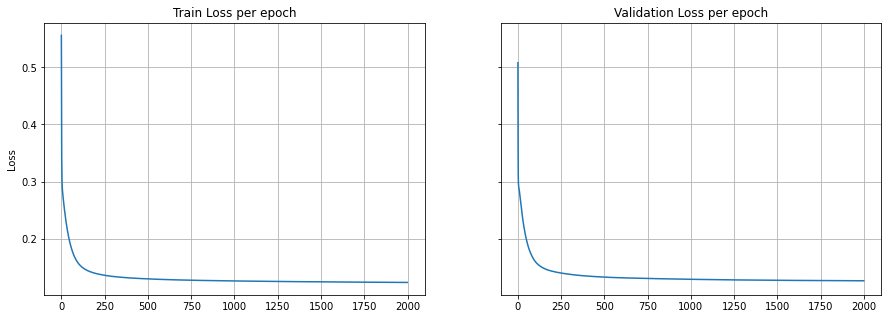

In [7]:
loss_ss = pd.Series(trainer.train_losses[1:])
validations_losses_ss = pd.Series(trainer.val_losses)

fig, ax = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)

loss_ss.plot(ax=ax[0])
validations_losses_ss.plot(ax=ax[1])
ax[0].set_ylabel('Loss')
ax[0].set_title('Train Loss per epoch')
ax[1].set_title('Validation Loss per epoch')
ax[0].grid()
ax[1].grid()

### 8 MODELS, ONE OUTPUT

In [8]:
# quantiles to predict
quantiles = torch.tensor([0.025, 0.05, 0.1, 0.15, 0.85, 0.9, 0.95, 0.975])

# number of inputs and outputs
n_inputs = frametorch.data.shape[1] - 1
n_outputs = 1

In [9]:
linear_models = []

for quantile in quantiles:
    # model
    linear_model = LinearNet(n_inputs=n_inputs, n_outputs=n_outputs)
    # criterion to use
    criterion = SmoothPinballLoss(quantile)
    # optimizer
    optimizer = optim.Adam(linear_model.parameters(), lr=0.0003)
    # trainer class
    trainer = Trainer(linear_model, criterion, optimizer)

    # train
    linear_model = trainer.fit(train_loader, val_loader, epochs=2000, n_logger=500, patience=50)
    linear_models.append(linear_model)

epoch: 0 train loss: 0.023 val loss: 0.008
epoch: 0 train loss: 0.016 val loss: 0.014
epoch: 0 train loss: 0.027 val loss: 0.021
epoch: 0 train loss: 0.051 val loss: 0.037
epoch: 0 train loss: 0.077 val loss: 0.07
epoch: 0 train loss: 0.097 val loss: 0.056
epoch: 0 train loss: 0.091 val loss: 0.028
epoch: 0 train loss: 0.065 val loss: 0.019


### VALIDATION PREDICTIONS 1 vs 8 MODELS

In [10]:
# validation input and target
inputs, target = frametorch.data_val[:, :-1], frametorch.data_val[:, -1:]
inputs = torch.tensor(inputs, dtype=torch.float32)
target = torch.tensor(target, dtype=torch.float32)
y_test = pd.Series(target.squeeze().tolist())

In [11]:
# quantilenet predictions
y_pred_quantilenet = quantilenet(inputs)
y_test = pd.Series(target.squeeze().tolist())
y_preds_quantilenet = pd.DataFrame(y_pred_quantilenet.tolist())

# linear predictions
y_preds_linear = []

for linear_model in linear_models:
    # predictions to pandas
    y_pred = linear_model(inputs)
    y_preds_linear.append(y_pred.squeeze().tolist())

y_preds_linear = pd.DataFrame(y_preds_linear).T
y_pred_linear = torch.tensor(y_preds_linear.values.tolist(), dtype=torch.float32)

### COMPARE MODEL TYPES

In [12]:
quantilenet_scores = get_scores(y_pred_quantilenet, target, quantiles)
linear_scores = get_scores(y_pred_linear, target, quantiles)

final_scores = pd.concat(
    [quantilenet_scores, linear_scores], axis=1, keys=['One model', 'Multiple models']
)
final_scores

,One model,Multiple models
QS,0.120002,0.117572
IS,0.409172,0.395792
Sharpnees,0.302130,0.297463
ACE,1.279967,2.050513


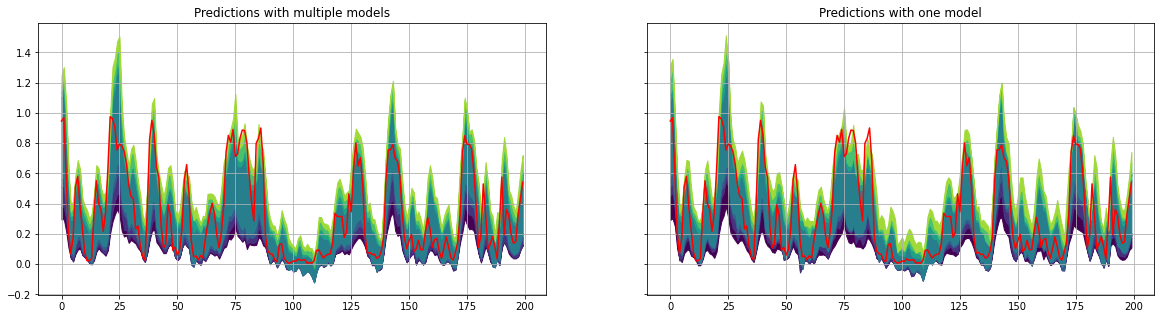

In [14]:
viridis = cm.get_cmap('viridis', len(quantiles))
fig, ax = plt.subplots(ncols=2, figsize=(20, 5), sharey=True)

for i in range(len(y_preds_linear.columns)-1):
    ax[0].fill_between(
        y_preds_linear.index[:200], 
        y_preds_linear[i][:200], 
        y_preds_linear[i+1][:200], 
        color=viridis.colors[i]
    )  
y_test[:200].plot(color='red', ax=ax[0])
ax[0].set_title('Predictions with multiple models')
ax[0].grid()

for i in range(len(y_preds_quantilenet.columns)-1):
    ax[1].fill_between(
        y_preds_quantilenet.index[:200], 
        y_preds_quantilenet[i][:200], 
        y_preds_quantilenet[i+1][:200], 
        color=viridis.colors[i]
    )
y_test[:200].plot(color='red', ax=ax[1])
ax[1].set_title('Predictions with one model')
ax[1].grid()